In [1]:
import cantera as ct
import numpy as np
import csv
from matplotlib import *
import matplotlib.pyplot as plt
import sys

In [2]:
#gas = ct.Solution(thermo='IdealGas', kinetics='GasKinetics', species=spec, reactions=rxns, name='my_custom_name')
gas = ct.Solution('BFER_methane.yaml', 'CH4_BFER_mix')       # create an object representing the gas phase
gas.TPX = 1000, 100000,{'CH4':1, 'O2':2, 'N2':7.52}      # set initial state

density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s

species_names = gas.species_names
molar_masses = gas.molecular_weights  # kg/kmol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y

print(gas())
print(f"Density: {density} kg/m³")
print(f"Kinematic Viscosity: {kinematic_viscosity} m²/s")
print(f"Thermal Conductivity: {thermal_conductivity} W/m/K\n\n")
for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    print(f"Molar Mass: {molar_masses[i]} kg/kmol")
    print(f"Mass Fraction: {mass_fractions[i]}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]} m²/s")
    print("")


  CH4_BFER_mix:

       temperature   1000 K
          pressure   1e+05 Pa
           density   0.33235 kg/m^3
  mean mol. weight   27.633 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        5.8795e+05        1.6247e+07  J
   internal energy        2.8706e+05        7.9325e+06  J
           entropy            8668.6        2.3954e+05  J/K
    Gibbs function       -8.0806e+06        -2.233e+08  J
 heat capacity c_p            1340.7             37049  J/K
 heat capacity c_v            1039.8             28734  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2           0.22014           0.19011           -28.239
               CH4          0.055187          0.095057           -36.551
                N2           0.72467           0.71483           -25.

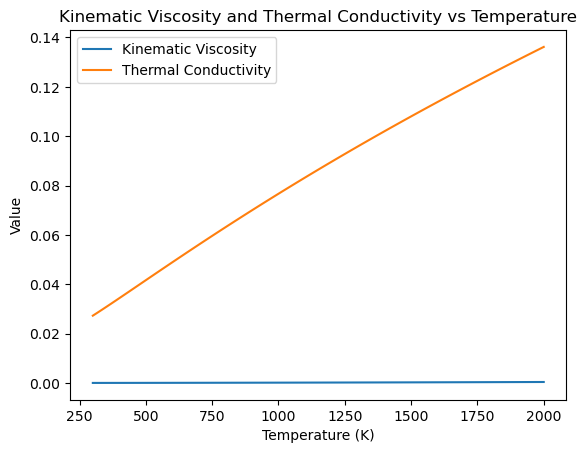

In [3]:
# Plot kinematic viscosity and thermal conductivity as a function of temperature
temperatures = np.linspace(300, 2000, 100)
kinematic_viscosity_values = np.zeros_like(temperatures)
thermal_conductivity_values = np.zeros_like(temperatures)

for i, T in enumerate(temperatures):
    gas.TP = T, 100000
    kinematic_viscosity_values[i] = gas.viscosity / gas.density
    thermal_conductivity_values[i] = gas.thermal_conductivity

plt.figure()
plt.plot(temperatures, kinematic_viscosity_values, label='Kinematic Viscosity')
plt.plot(temperatures, thermal_conductivity_values, label='Thermal Conductivity')
plt.xlabel('Temperature (K)')
plt.ylabel('Value')
plt.legend()
plt.title('Kinematic Viscosity and Thermal Conductivity vs Temperature')
plt.show()

In [4]:
gas.equilibrate('HP')                 # equilibrate using Temperature (T) and Pressure (P)
density = gas.density
viscosity = gas.viscosity
thermal_conductivity = gas.thermal_conductivity
kinematic_viscosity = viscosity / density  # m²/s

species_names = gas.species_names
molar_masses = gas.molecular_weights  # kg/kmol
diff_coeffs = gas.mix_diff_coeffs  # m²/s
mass_fractions = gas.Y

print(gas())
print(f"Density: {density} kg/m³")
print(f"Kinematic Viscosity: {kinematic_viscosity} m²/s")
print(f"Thermal Conductivity: {thermal_conductivity} W/m/K\n\n")
for i, specie in enumerate(species_names):
    print(f"Species: {specie}")
    print(f"Molar Mass: {molar_masses[i]} kg/kmol")
    print(f"Mass Fraction: {mass_fractions[i]}")
    print(f"Mix Diffusion Coefficient: {diff_coeffs[i]} m²/s")
    print("")


  CH4_BFER_mix:

       temperature   3310 K
          pressure   1e+05 Pa
           density   0.096614 kg/m^3
  mean mol. weight   26.589 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        2.0429e+06        5.4317e+07  J
   internal energy        1.0078e+06        2.6797e+07  J
           entropy             10713        2.8485e+05  J/K
    Gibbs function       -3.3418e+07       -8.8854e+08  J
 heat capacity c_p            1560.8             41500  J/K
 heat capacity c_v            1248.1             33186  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
                O2          0.045489            0.0378           -33.966
               H2O           0.12394           0.18293            -40.41
               CH4        1.0359e-13        1.7169e-13           -66

We will now perform **several constant pressure equilibrium calculations of an ethylene/air mixture, at
an initial temperature of 300K and under atmospheric pressure**, in order to obtain the adiabatic flame temperature and burnt gas state for several equivalence ratios.<br>
The goal of this exercise is to find a way to loop through several gaseous composition, in order to perform several computations in a single script; and to learn how to properly store the results in a *csv* file.

In [ ]:
gas = ct.Solution('CK2CTI/mech.yaml')

T = 300.0                     # Temperature
P = 101325.0                  # Pressure

phi_min = 0.3                 # Minimal equivalence ratio
phi_max = 3.5                 # Maximal equivalence ratio
npoints = 50                  # Point in-between the two preceeding values

fuel_species = 'C2H4'         # fuel species
air_N2_O2_molar_ratio = 3.76  # ratio representing the air

### Loop of equilibrium

In [ ]:
phi = np.zeros(npoints)                  # 1D array
tad = np.zeros(npoints)                  # 1D array

xeq = np.zeros((gas.n_species, npoints)) # 2D array

for i in range(npoints):

    gas.TP = T, P
    
    phi[i] = phi_min + (phi_max - phi_min) * i / (npoints - 1)
    gas.set_equivalence_ratio(phi[i], {fuel_species: 1}, {'O2': 1, 'N2': air_N2_O2_molar_ratio})

    gas.equilibrate('HP') # Equilibrate the mixture adiabatically at constant P with the solver vcs
    
    xeq[:, i] = gas.X
    tad[i] = gas.T
    print("At phi = ","%10.4f"% (phi[i])+ "  Tad = ","%10.4f"% (tad[i]))

### Save files

In [ ]:
csv_file = 'result_2.csv'
with open(csv_file, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Phi', 'T (K)'] + gas.species_names)
    for i in range(npoints):
        writer.writerow([phi[i], tad[i]] + list(xeq[:, i]))
print("Output written to", "%s" % csv_file)

### Plot the results

In [ ]:
rcParams['figure.figsize'] = (14, 10)

plt.plot(phi, tad, '-')

plt.title(r'Tad vs. $\Phi$ for $C_{2}H_{4}/Air$ flames')
plt.xlabel(r'$\Phi$', fontsize=20)
plt.ylabel("Adiabatic flame temperature (K)")

plt.grid()

plt.show()
plt.savefig('plot_tad.png', bbox_inches='tight')

In [ ]:
for i, cas in enumerate(gas.species_names):
    if cas in ['O2','CO2','CO']:
        plt.plot(phi,xeq[i,:], label = cas)
        plt.xlabel('Equivalence ratio')
        plt.ylabel('Mole fractions')
        plt.legend(loc='best')
        plt.show()

## Conclusion

We have just generated the skeleton of a script to perform a series of common equilibrium calculations
to obtain the constant pressure equilibrium composition of a fuel/air mixture. Starting from there,
you could modify your initial conditions, plot the mole/mass fractions of other species, change the
solver or even try another fuel (methane, acetylene) without changing your mechanism.<br>
Technically, adiabatic flame calculations could also be performed at constant volume: simply invoke
the good equilibrate option of your equilibrate function, 'UV' (see 3.1.2), in your script.